# Drug Interactions Network Analysis
### Part 2 - Network Analysis and Visualization with NetworkX and PyVis

#### References
- https://pyvis.readthedocs.io/en/latest/documentation.html
- https://networkx.org/documentation/stable/
- https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python
- https://docs.datapane.com/

#### Author: Kenneth Leung

___
## 1. Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import zipfile
import json
from pyvis.network import Network
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community #This part of networkx, for community detection, needs to be imported separately
import datapane as dp

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

___
## 2. Data preparation

In [2]:
# Unzip all tar/zip files
zip_files_list = [i for i in os.listdir('data') if i.endswith('.zip')]

for file in zip_files_list:
    with zipfile.ZipFile(f'data/{file}', 'r') as zip_ref:
        zip_ref.extractall('data')

<IPython.core.display.Javascript object>

#### 2(a) - Drug Interactions (Drugbank)

In [3]:
# Read DB mapping JSON
with open('data/DB_mapping.json', 'r') as fp:
    db_mapping = json.load(fp)

# Import raw drugbank dataset
df_db_int = pd.read_csv("data/ChCh-Miner_durgbank-chem-chem.tsv", sep='\t', header=None)
df_db_int.columns = ['drug_1_code', 'drug_2_code']

# Perform code-name mapping
df_db_int['drug_1_name'] = df_db_int['drug_1_code'].map(db_mapping)
df_db_int['drug_2_name'] = df_db_int['drug_2_code'].map(db_mapping)

# Clean data 
df_db_int = df_db_int[~df_db_int['drug_1_name'].isin(['This record has been revoked'])]
df_db_int = df_db_int[~df_db_int['drug_2_name'].isin(['This record has been revoked'])]

# Rename columns
new_cols = ['drug_1_code', 'drug_1_name', 'drug_2_code', 'drug_2_name']
df_db_int = df_db_int[new_cols]
df_db_int.head()

,drug_1_code,drug_1_name,drug_2_code,drug_2_name
0,DB00862,Vardenafil,DB00966,Telmisartan
1,DB00575,Clonidine,DB00806,Pentoxifylline
2,DB01242,Clomipramine,DB08893,Mirabegron
3,DB01151,Desipramine,DB08883,Perampanel
4,DB01235,Levodopa,DB01275,Hydralazine


In [4]:
len(df_db_int)

48464

#### 2(b) - Polypharmacy side effects
- Not using this dataset for drug interactions analysis

In [5]:
# # Read CID mapping JSON
# with open('data/CID_mapping.json', 'r') as fp:
#     cid_mapping = json.load(fp)
    
# # Import dataset
# df_poly_se = pd.read_csv("data/ChChSe-Decagon_polypharmacy.csv")
# df_poly_se.columns = ['drug_1_code', 'drug_2_code', 'side_effect_code', 'side_effect_description']

# # Perform code-name mapping
# df_poly_se['drug_1_name'] = df_poly_se['drug_1_code'].map(cid_mapping)
# df_poly_se['drug_2_name'] = df_poly_se['drug_2_code'].map(cid_mapping)

# # Rearrange columns
# new_cols = ['drug_1_code', 'drug_1_name', 'drug_2_code', 'drug_2_name', 
#             'side_effect_code', 'side_effect_description']

# df_poly_se = df_poly_se[new_cols]
# df_poly_se.head()

#### 2(c) - Monopharmacy side effects
- Not using this dataset for drug interactions analysis

In [6]:
# df_mono_se = pd.read_csv("data/ChSe-Decagon_monopharmacy.csv")

# # Import dataset
# df_mono_se = pd.read_csv("data/ChSe-Decagon_monopharmacy.csv")
# df_mono_se.columns = ['drug_code', 'side_effect_code', 'side_effect_description']

# # Perform code-name mapping
# df_mono_se['drug_name'] = df_mono_se['drug_code'].map(cid_mapping)

# # Rearrange columns
# new_cols = ['drug_code', 'drug_name', 'side_effect_code', 'side_effect_description']

# df_mono_se = df_mono_se[new_cols]
# df_mono_se.head()

___
## 3. Network Analysis (with NetworkX)

#### DrugBank Drug Interactions

In [5]:
# Set weights as default value of 1
df_db_int['weight'] = 1

# Keep only drug name columns
df_db_int = df_db_int[['drug_1_name', 'drug_2_name', 'weight']]
df_db_int.head()

,drug_1_name,drug_2_name,weight
0,Vardenafil,Telmisartan,1
1,Clonidine,Pentoxifylline,1
2,Clomipramine,Mirabegron,1
3,Desipramine,Perampanel,1
4,Levodopa,Hydralazine,1


In [6]:
# Generate a networkx graph
G = nx.from_pandas_edgelist(df_db_int, 'drug_1_name', 'drug_2_name')

# Give the graph a name
G.name = 'Drug Interactions Network'

# Check whether graph is directed or undirected (False = undirected)
print(G.is_directed())

# Obtain general information of graph
print(nx.info(G))

# Get graph density
density = nx.density(G)
print("Network density:", density)

False
Name: Drug Interactions Network
Type: Graph
Number of nodes: 1505
Number of edges: 48224
Average degree:  64.0850
Network density: 0.042609740581041916


In [7]:
# Get most connected node (i.e. drug with most drug interactions)
G.degree()
max(dict(G.degree()).items(), key = lambda x : x[1])

('Phenytoin', 442)

In [8]:
# Create dictionary to store degrees of nodes
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

# Generate sorted list of tuples of drug entity and corresponding degree
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 drugs by degree:")
for d in sorted_degree[:20]:
    print(d)

Top 20 drugs by degree:
('Phenytoin', 442)
('Mifepristone', 377)
('Paroxetine', 368)
('Tranylcypromine', 358)
('Phenelzine', 342)
('Warfarin', 334)
('Deferasirox', 329)
('Nelfinavir', 321)
('Dronabinol', 312)
('Hydrocodone', 311)
('Clozapine', 311)
('Primidone', 307)
('Ritonavir', 306)
('Aripiprazole', 304)
('Fosphenytoin', 300)
('Saquinavir', 293)
('Acenocoumarol', 292)
('Carbamazepine', 290)
('Citalopram', 288)
('Dabrafenib', 285)


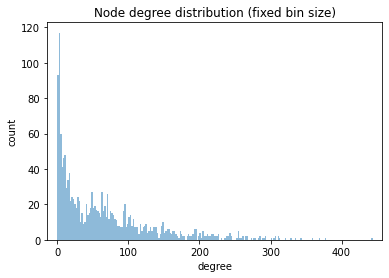

In [9]:
sorted_degree_values = [pair[1] for pair in sorted_degree]

# fixed bin size
bins = np.arange(0, 450, 2) # fixed bin size

plt.xlim([min(sorted_degree_values)-15, max(sorted_degree_values)+15])
plt.hist(sorted_degree_values, bins=bins, alpha=0.5)
plt.title('Node degree distribution (fixed bin size)')
plt.xlabel('degree')
plt.ylabel('count')
plt.show()

In [10]:
# Get degree centrality (corresponds with degree)
degree_centrality = nx.degree_centrality(G)
degree_centrality = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
degree_centrality

{'Phenytoin': 0.29388297872340424,
 'Mifepristone': 0.25066489361702127,
 'Paroxetine': 0.24468085106382978,
 'Tranylcypromine': 0.23803191489361702,
 'Phenelzine': 0.22739361702127658,
 'Warfarin': 0.2220744680851064,
 'Deferasirox': 0.21875,
 'Nelfinavir': 0.21343085106382978,
 'Dronabinol': 0.2074468085106383,
 'Hydrocodone': 0.20678191489361702,
 'Clozapine': 0.20678191489361702,
 'Primidone': 0.2041223404255319,
 'Ritonavir': 0.20345744680851063,
 'Aripiprazole': 0.20212765957446807,
 'Fosphenytoin': 0.19946808510638298,
 'Saquinavir': 0.19481382978723405,
 'Acenocoumarol': 0.19414893617021275,
 'Carbamazepine': 0.19281914893617022,
 'Citalopram': 0.19148936170212766,
 'Dabrafenib': 0.18949468085106383,
 'Dasatinib': 0.18882978723404256,
 'Methotrimeprazine': 0.18816489361702127,
 'Brimonidine': 0.18550531914893617,
 'Ethanol': 0.18351063829787234,
 'Tacrolimus': 0.1815159574468085,
 'Ceritinib': 0.17752659574468085,
 'Darunavir': 0.17752659574468085,
 'Idelalisib': 0.176196808510

In [11]:
# Betweenness centrality not relevant for drug-drug interactions dataset, so not running this chunk of code
# betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
# eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# # Assign each to an attribute in your network
# nx.set_node_attributes(G, betweenness_dict, 'betweenness')
# nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

# sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

# print("Top 20 nodes by betweenness centrality:")
# for b in sorted_betweenness[:20]:
#     print(b)

___
## 4. Network Visualization (with Pyvis)

In [11]:
# Define function to generate Pyvis visualization
def generate_network_viz(df, source_col, target_col, weights, 
                         layout='barnes_hut',
                         central_gravity=0.15,
                         node_distance=420,
                         spring_length=100,
                         spring_strength=0.15,
                         damping=0.96
                         ):
    
    # Generate a networkx graph
    G = nx.from_pandas_edgelist(df, source_col, target_col, weights)
    
    if layout == 'repulsion':
        bgcolor, font_color = '#222222', 'white'
    else:
        bgcolor, font_color = 'white', 'black'
    
    # Initiate PyVis network object
    drug_net = Network(
                       height='700px', 
                       width='100%',
                       bgcolor=bgcolor, 
                       font_color=font_color, 
                       notebook=True
                      )
    
    # Take Networkx graph and translate it to a PyVis graph format
    drug_net.from_nx(G)
    
    # Create different network layout (repulsion or Barnes Hut)
    if layout == 'repulsion':
        drug_net.repulsion(
                            node_distance=node_distance, 
                            central_gravity=central_gravity, 
                            spring_length=spring_length, 
                            spring_strength=spring_strength, 
                            damping=damping
                           )
        
    # Run default Barnes Hut visualization
    else:
        drug_net.barnes_hut(
#                            gravity=-80000, 
#                            central_gravity=central_gravity, 
#                            spring_length=spring_length, 
#                            spring_strength=spring_strength, 
#                            damping=damping, 
#                            overlap=0
                          )      
        
    # Set additional options ()
    # db_net_sm.set_options("""
#             var options = {
#               "edges": {
#                 "color": {
#                   "inherit": true
#                 },
#                 "font": {
#                   "size": 25,
#                   "strokeWidth": 3
#                 },
#                 "scaling": {
#                   "max": 14
#                 },
#                 "smooth": false
#               },
#               "interaction": {
#                 "tooltipDelay": 100
#               }
#             }
#             """)
        
#     # Create neighbour map (Optional for now)
#     sources = df[source_col]
#     targets = df[target_col]
#     weights = df[weights]

#     edge_data = zip(sources, targets, weights)
#     for e in edge_data:
#         src = e[0]
#         dst = e[1]
#         w = e[2]

#         df.add_node(src, src, title=src)
#         df.add_node(dst, dst, title=dst)
#         df.add_edge(src, dst, value=w)

#     # Add neighbor data to node hover data
#     # neighbor_map = df.get_adj_list()

#     # for node in db_net.nodes:
#     #     node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
#     #     node['value'] = len(neighbor_map[node['id']])

    return drug_net

In [13]:
# Load entire network for all drug interactions (Will take very long to load, run this code with caution)
# db_net_all = generate_network_viz(df_db_int, 'drug_1_name', 'drug_2_name', 'weight')
# db_net_all.show('drug_interactions_db.html')

___
#### Subset data
- Earlier network is too vast and complex for viewing
- Narrow down dataset to subset of drugs for network visualization

In [12]:
# Define list of oral medications for the common diseases
dm_meds = ['Metformin', 'Linagliptin', 'Sitagliptin', 'Glibenclamide', 'Gliclazide',
          'Glimepiride', 'Glipizide', 'Tolbutamide', 'Canagliflozin', 'Dapagliflozin',
          'Empagliflozin', 'Dapagliflozin', 'Acarbose', 'Liraglutide']

cardio_meds = ['Captopril', 'Enalapril', 'Lisinopril', 'Perindopril', 'Irbesartan',
               'Losartan', 'Telmisartan', 'Valsartan', 'Candesartan', 'Atenolol', 
               'Bisoprolol', 'Carvedilol', 'Propranolol', 'Amlodipine', 'Diltiazem', 
               'Nifedipine', 'Verapamil', 'Bumetanide', 'Frusemide', 'Isosorbide',
               'Hydrochlorothiazide', 'Spironolactone', 'Isosorbide Dinitrate', 
               'Isosorbide Mononitrate', 'Aspirin', 'Clopidogrel', 'Ticagrelor', 
               'Atorvastatin', 'Rosuvastatin', 'Simvastatin', 'Pravastatin']  

# List of meds with the most interactions
subset_meds_1 = ['Phenytoin', 'Mifepristone', 'Paroxetine']

# Sample drugs for diabetes (Metformin), hyperlipidemia (Simvastatin), and hypertension (Lisinopril)
subset_meds_2 = ['Metformin', 'Simvastatin', 'Lisinopril']

In [13]:
# Focus on subset meds
df_db_int_sm = df_db_int.loc[df_db_int['drug_1_name'].isin(subset_meds_2) | df_db_int['drug_2_name'].isin(subset_meds_2)]
df_db_int_sm = df_db_int_sm.reset_index(drop=True)
df_db_int_sm.head()

,drug_1_name,drug_2_name,weight
0,Simvastatin,Siltuximab,1
1,Metformin,Phenelzine,1
2,Simvastatin,Eltrombopag,1
3,Metformin,Primidone,1
4,Simvastatin,Fenofibrate,1


#### Network visualization with Repulsion
- Solver attribute of physics to repulsion.

In [22]:
# Generate a networkx graph based on subset data
db_subset_net = generate_network_viz(df_db_int_sm, 'drug_1_name', 'drug_2_name', 'weight', layout='repulsion')

# Display interactive graph
db_subset_net.show('drug_interactions_network_subset_repulsion.html')

# Run the above code chunk in order to display the graph visualization below

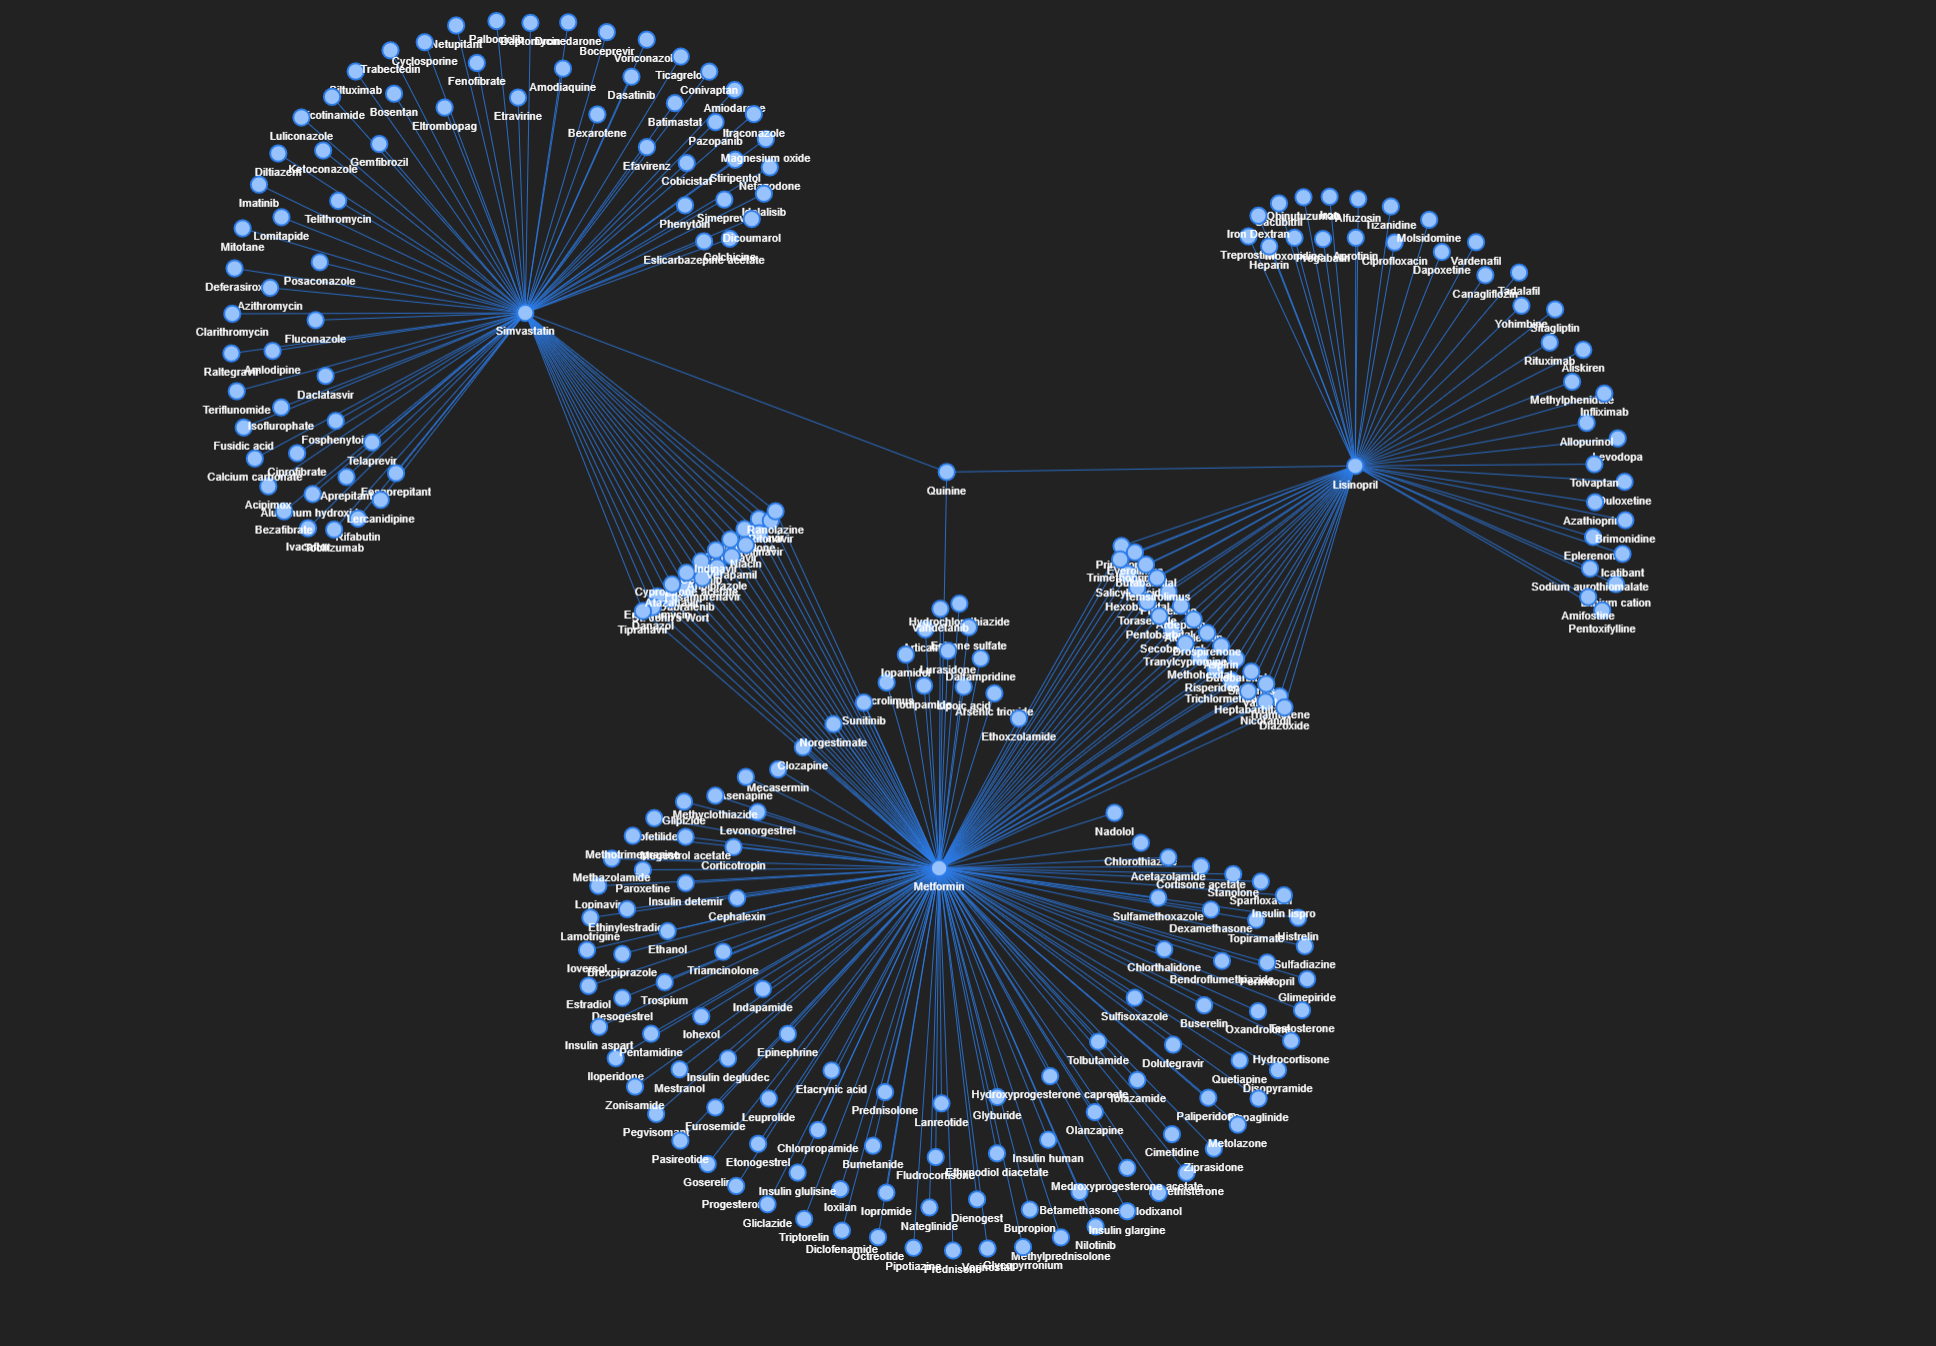

#### Barnes Hut Visualization
- BarnesHut is a quadtree based gravity model
- It is the fastest, default and recommended solver for non-hierarchical layouts

In [23]:
# Generate a networkx graph based on subset data
db_subset_net_barnes = generate_network_viz(df_db_int_sm, 'drug_1_name', 'drug_2_name', 'weight', layout='barnes')
db_subset_net_barnes.show('drug_interactions_network_subset_barnes.html')

# Run the above code chunk in order to display the graph visualization below

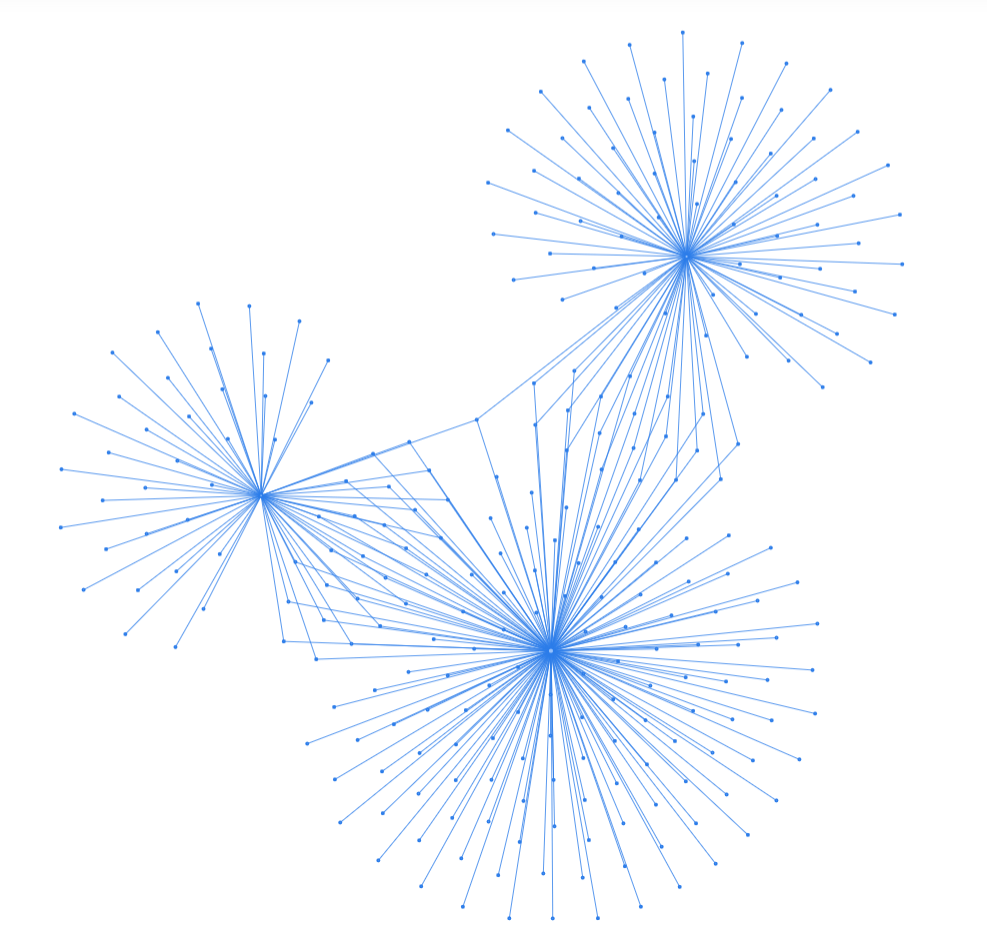
___

In [24]:
# Create network for single drug. Use Phenytoin since it has most edges (i.e. involved in most drug interactions)
df_db_phenytoin = df_db_int.loc[df_db_int['drug_1_name'].isin(['Phenytoin']) | df_db_int['drug_2_name'].isin(['Phenytoin'])]

# Generate a networkx graph based on subset data
db_net_phenytoin = generate_network_viz(df_db_phenytoin, 'drug_1_name', 'drug_2_name', 'weight', layout='repulsion', spring_strength=0.05)
db_net_phenytoin.show('drug_interactions_network_phenytoin.html')

# Run the above code chunk in order to display the graph visualization below

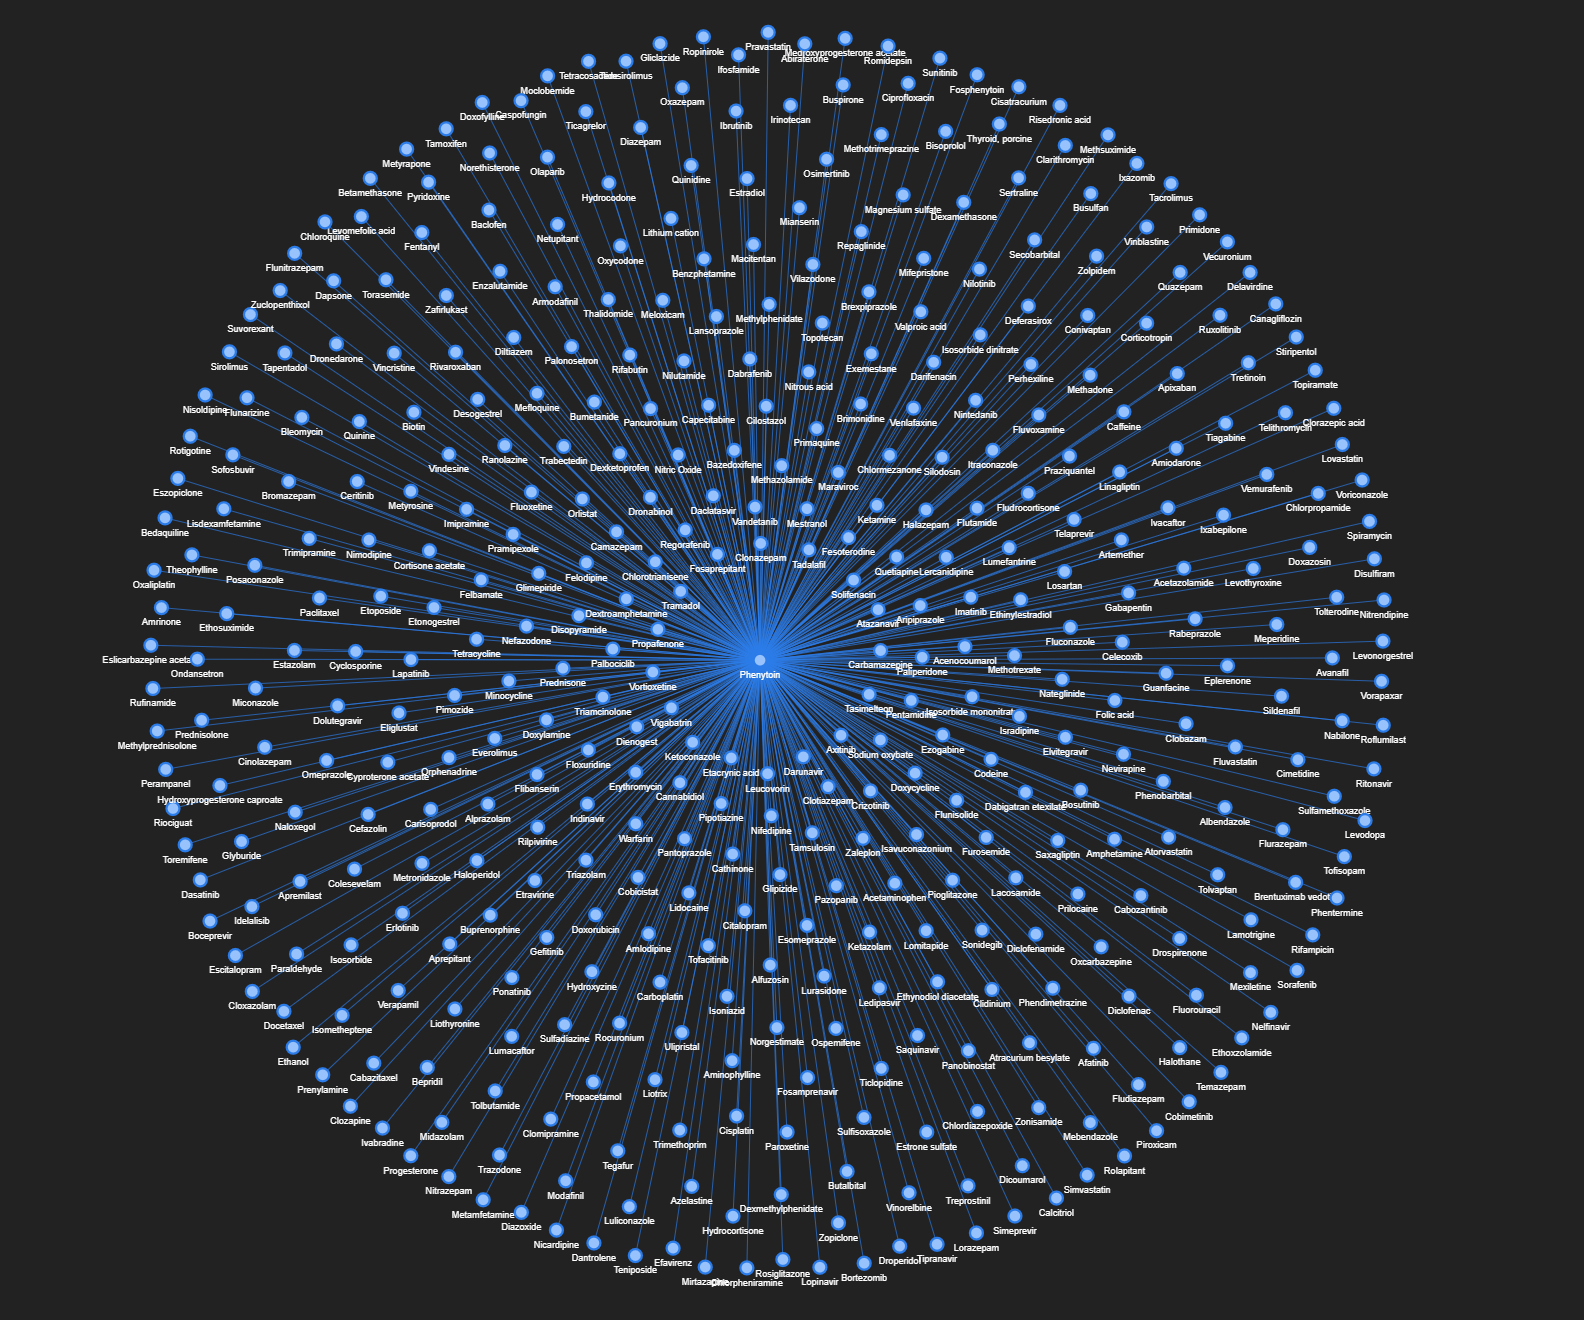

In [54]:
df_db_phenytoin

,drug_1_name,drug_2_name,weight
66,Phenytoin,Propafenone,1
112,Phenytoin,Ketoconazole,1
147,Phenytoin,Etacrynic acid,1
300,Phenytoin,Darunavir,1
305,Phenytoin,Tasimelteon,1
...,...,...,...
47633,Phenytoin,Meloxicam,1
47765,Phenytoin,Vinblastine,1
48246,Phenytoin,Ivacaftor,1
48300,Phenytoin,Mebendazole,1


___
#### Refer to the `upload_viz_to_datapane.py` script for the codes to upload these network graphs (as HTML files) into DataPane for better visualization
- Run the .py script in CLI

In [21]:
# Display code in .py script
!pygmentize upload_viz_to_datapane.py

# Upload HTMLs to Datapane
# Reference: https://docs.datapane.com/reports/blocks/text-code-and-html
import datapane as dp

# =====================================
#  Network 1 - Subset Data (Repulsion)
# =====================================
with open('drug_interactions_network_subset_repulsion.html', 'r') as f:
    html_network_1 = f.read()

dp.Report(
  dp.HTML(
    html_network_1
  )
).upload(name='drug_interactions_network_1.html')

# =====================================
#  Network 2 - Subset Data (Barnes_Hut)
# =====================================
with open('drug_interactions_network_subset_barnes.html', 'r') as f:
    html_network_2 = f.read()

dp.Report(
  dp.HTML(
    html_network_2
  )
).upload(name='drug_interactions_network_2.html')

# =====================================
#         Network 3 - Phenytoin
# =====================================
with open('drug_interactions_network_phenytoin.html', 'r') as f:
    html_network_3 = f.read()

dp.Report(
  dp.HTML(
    html_netw